# ML approach

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ML Preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

# ML modelling
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
from sklearn.model_selection import GridSearchCV

# ML evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE


In [ ]:
# Open dataset
df = pd.read_csv(os.path.join(os.getcwd(),'..','dataset','clean_df.csv'))

# Shuffle dataset
df = df.sample(n=len(df), random_state=42)
df.head()

# Data Analysis

In [ ]:
spike_cols = [col for col in df.columns if 'mfcc' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig("mfcc_matrix");

# Data cleaning

In [ ]:
# Grab relevant data
X = df.iloc[:,:-4]
y = df.iloc[:,-4]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

In [ ]:
# Pipeline

# Standardization
stdz = make_pipeline(RobustScaler())

# Add all preprocessig steps together
preprocessing = [
    ('scaler', stdz, list(X.columns))
]

# Encode features with prprocessing steps
features_encoder = ColumnTransformer(preprocessing,remainder="drop")

# Build pipeline
pipeline = Pipeline(steps=[
            ('features', features_encoder)])


X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

## Select and Build model

In [9]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [10]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.56155 

Accuracy Stochastic Gradient Descent : 0.68951 

Accuracy KNN : 0.69375 

Accuracy Decission trees : 0.61674 

Accuracy Random Forest : 0.7926 

Accuracy Support Vector Machine : 0.8017 



c:\users\chris\.venvs\lewagon\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy Logistic Regression : 0.77987 

Accuracy Neural Nets : 0.79867 

Accuracy Cross Gradient Booster : 0.83808 

Accuracy Cross Gradient Booster (Random Forest) : 0.72286 



# XGBClassifier

### Baseline

In [16]:
names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

Accuracy : 0.83808 



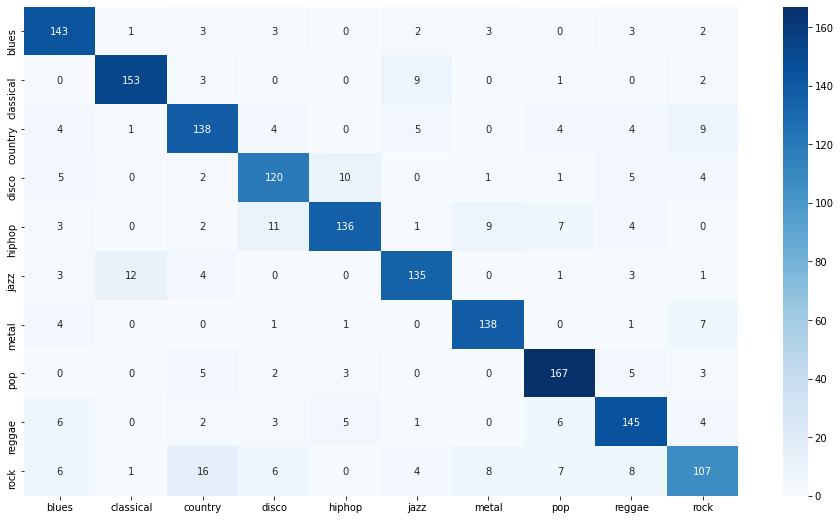

In [17]:
# Final model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)


preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = names,
           yticklabels=names,
           fmt="d");
plt.savefig("accuracy_confusion_matrix")

### [FINETUNING]   - Grid searching

In [196]:
estimator = XGBClassifier(nthread=4,seed=42)

parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

In [197]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 66.5min finished


Best: 0.857755 using {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 180}
0.741501 (0.020859) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60}
0.781546 (0.020646) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
0.800671 (0.013100) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 140}
0.809335 (0.011152) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}
0.811422 (0.016242) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 60}
0.839525 (0.022312) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.851181 (0.018353) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 140}
0.857755 (0.016317) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 180}
0.825469 (0.018965) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}
0.841310 (0.018685) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
0.847584 (0.015126) with: {'learning_rate': 0.1, 'max_depth': 

NameError: name 'pyplot' is not defined

### Run model

In [11]:
estimator = XGBClassifier(nthread=4,seed=42)

parameters = {
    'max_depth': range(4,6,1),
    'n_estimators': range(200, 400, 10),
    'learning_rate': [0.1]
}

grid_search2 = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=10
)

grid_result2 = grid_search2.fit(X_train, y_train)
# summarize results

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 75.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 83.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 103.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 118.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 140.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:

In [12]:
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.867613 using {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 370}
0.859846 (0.015267) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
0.859846 (0.016617) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 210}
0.861338 (0.016623) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 220}
0.862835 (0.017404) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 230}
0.863730 (0.017908) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 240}
0.863133 (0.017727) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250}
0.862534 (0.016334) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 260}
0.865222 (0.015760) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 270}
0.864923 (0.014970) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 280}
0.865220 (0.014962) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 290}
0.866416 (0.014756) with: {'learning_rate': 0.1, 'max_depth

### tune learning rate

In [13]:
estimator = XGBClassifier(nthread=4,seed=42)

parameters = {
    'max_depth': range(4,6,1),
    'n_estimators': range(200, 400, 40),
    'learning_rate': [0.05]
}

grid_search3 = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=10
)

grid_result3 = grid_search3.fit(X_train, y_train)
# summarize results

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 52.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 67.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 84.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 97.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 100.9min finished


In [14]:
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_['mean_test_score']
stds = grid_result3.cv_results_['std_test_score']
params = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.856856 using {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 360}
0.839520 (0.018916) with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
0.846693 (0.016549) with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 240}
0.850875 (0.015072) with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 280}
0.852669 (0.016734) with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 320}
0.856850 (0.014680) with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 360}
0.843703 (0.019136) with: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.850877 (0.017992) with: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 240}
0.854762 (0.018181) with: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 280}
0.855359 (0.015586) with: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 320}
0.856856 (0.015404) with: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 360}


# Full fledged pipeline

In [18]:
#---------------------------------------------------------
#  Retrieve data
#---------------------------------------------------------

def get_data(test_size=0.33):
    # Open dataset
    df = pd.read_csv(os.path.join(os.getcwd(),'..','dataset','clean_df.csv'))

    # Shuffle dataset
    df = df.sample(n=len(df), random_state=42)
    # Grab relevant data
    X = df.iloc[:,:-4]
    y = df.iloc[:,-4]

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test 

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [44]:
#---------------------------------------------------------
#  Build pipeline
#---------------------------------------------------------


def pipeline(save_locally = False, cross_val = False):
    # Load data
    X_train, X_test, y_train, y_test = get_data()
    
    # Standardization
    stdz = make_pipeline(RobustScaler())

    # Add all preprocessig steps together
    preprocessing = [
        ('scaler', stdz, list(X.columns))
    ]

    # Encode features with prprocessing steps
    features_encoder = ColumnTransformer(preprocessing,remainder="drop")
    
    # Model
    xgb = XGBClassifier(learning_rate =  0.1, max_depth = 4, n_estimators = 370)
    

    # Build pipeline
    pipeline = Pipeline(steps=[
                ('features', features_encoder),
                ('model', xgb)])
    
    # Fit model
    if cross_val == True :
        result = cross_val_score(pipeline, X_train, y_train, cv=10)
        y_pred = cross_val_predict(pipeline, X_test, y_test, cv=10)
        accuracy = round(accuracy_score(y_test, y_pred))
    else :
        pipeline  = pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test, y_test)
        accuracy = round(accuracy_score(y_test, y_pred))
    
    # Save model
    if save_locally == True :
        print('# Saved Locally')
        pass
                                      
    return accuracy, result, y_pred

In [46]:
accuracy, result, y_pred = pipeline()

TypeError: predict() takes 2 positional arguments but 3 were given

In [45]:
y_pred

array([0, 5, 9, ..., 9, 7, 9], dtype=int64)

In [28]:
result, y_pred = pipeline()

In [31]:
np.mean(result)

0.8511688195792338

In [ ]:
round(accuracy_score(y_test, preds)